In [1]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib
from collections import OrderedDict
import itertools
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

In [2]:
%store -r da_dv
%store -r da_bv
%store -r da_sw
%store -r da_dcs


da_dv = da_dv.load()

## Raw Delta V 

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


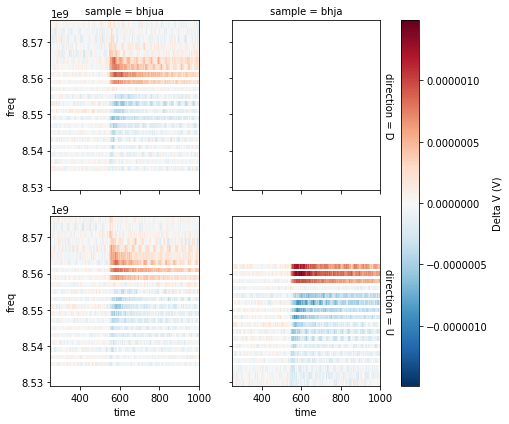

In [3]:
da_dv.name = 'Delta V (V)'

col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
g = da_dv.dropna('fluence','all').mean('fluence').sel(time = slice(250e-9,1000e-9)).plot(x = 'time', y = 'freq', row = 'direction', col = col)
# g.fig.autofmt_xdate()

for axs in g.axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

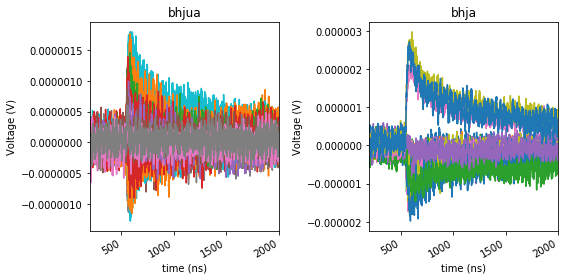

In [4]:
size = len(da_dv.indexes['sample'])
fig, axes = plt.subplots(1,size, figsize = (4*size, 2*size), squeeze=False)

for i,samp in enumerate(da_dv.indexes['sample']):
    data = da_dv.sel(sample = samp).sel(direction = 'U').dropna('fluence','all').isel(fluence = -1).dropna('time','all')
    ax = axes[0][i]
    f0 = 8.542e9
    freqs = data.indexes['freq']
    for freq in freqs:
        trace = data.sel(freq = freq).dropna('time','all')
        ax.plot(trace.to_series())
#     ax = plot.redbluetransient(ax,data, f0)
    ax.set_title(samp)
    ax.set_xlim([200e-9,2000e-9])
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('Voltage (V)')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

# ax.legend()
fig.autofmt_xdate()
fig.tight_layout()

## Normalized Delta V 

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


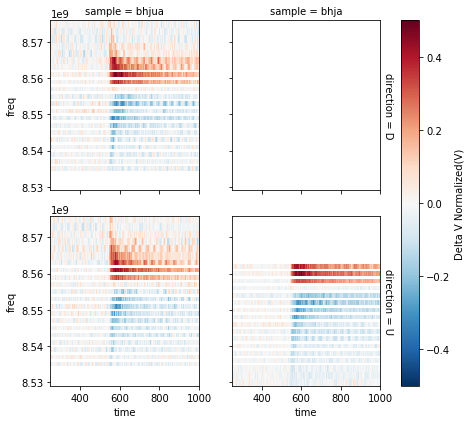

In [5]:
def norm(x):
    return x/x.max()

da_dv_norm = da_dv.groupby('sample').apply(norm)

da_dv_norm.name = 'Delta V Normalized(V)'

col = None if (len(da_dv_norm.indexes['sample']) == 1)  else 'sample'
g = da_dv_norm.dropna('fluence','all').mean('fluence').sel(time = slice(250e-9,1000e-9)).plot(x = 'time', y = 'freq', row = 'direction', col = col)
# g.fig.autofmt_xdate()

for axs in g.axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

## load in and plot the dark cavity sweeps

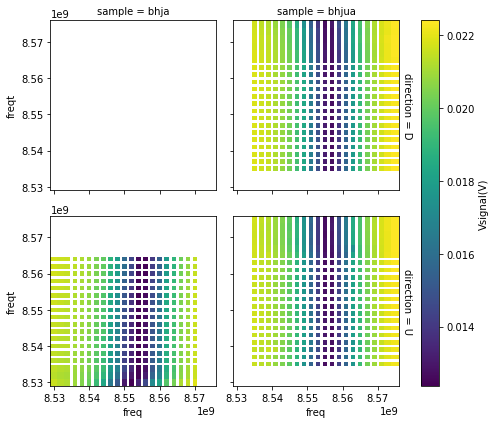

In [6]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
da_dcs.plot(x = 'freq',y='freqt',row = 'direction',col = col)

bhja
bhjua


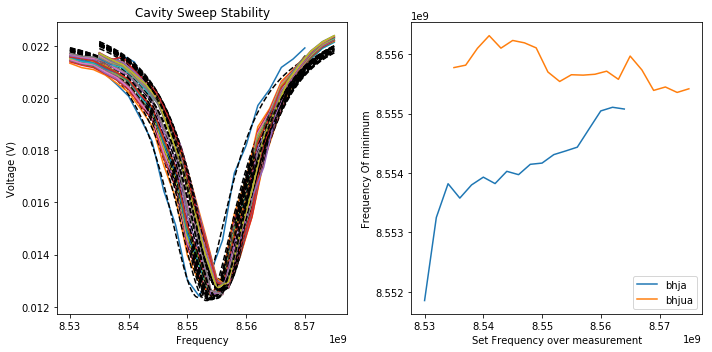

In [7]:
p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100

fig, axes = plt.subplots(1,2, figsize = (10,5))

daf0s = []
for samp in da_dcs.indexes['sample']:
    print(samp)
    da = da_dcs.sel(sample = samp).sel(direction = 'U').dropna('freq','all').dropna('freqt','all')
    f0s = []
    for freqt in da.indexes['freqt']:
        d = da.sel(freqt = freqt)
        axes[0].plot(d.to_series())

        Rinf = 0.02125
        f0 = d.to_series().idxmin()
        p0 =[f0,1e7,0.01, Rinf]

        v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
        popt = v0_p[0]
        f0s.append(popt[0])

        freqs = da.indexes['freq']
        freqs_i = np.linspace(freqs.min(),freqs.max(),100)
        dfit = v0_fit(freqs_i)
        dfit = pd.Series(dfit, index = freqs_i)
        axes[0].plot(dfit, color = 'black', linestyle = '--')
    
    daf0s.append(xr.DataArray(f0s, coords = {'freqt' : da.indexes['freqt']}, dims= ['freqt']).assign_coords(sample = samp).expand_dims('sample'))


daf0s = xr.concat(daf0s, dim = 'freqt')

for samp in daf0s.indexes['sample']:
    axes[1].plot(daf0s.sel(sample = samp).to_series(), label = samp)

axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Voltage (V)')

axes[1].legend()
axes[1].set_ylabel('Frequency Of minimum')
axes[1].set_xlabel('Set Frequency over measurement')
axes[0].set_title('Cavity Sweep Stability')
fig.tight_layout()

## Interpolate the dark cavity sweep to match with the delta v data array

In [8]:
da_dcsi = da_dcs.interp_like(da_dv,method = 'nearest')

For now just pull out one freqt

In [9]:
# For partial data sets, cut down the dark cavity sweep, not sure if this is nessecary
# fmin = da_dv.indexes['freq'].min()
# fmax = da_dv.indexes['freq'].max()
# idxmin = abs(da_dcs.indexes['freq'] - fmin).argmin()
# idxmax = abs(da_dcs.indexes['freq'] - fmax).argmin() + 1 #???

idx = 5
das = []
for samp in da_dcsi.indexes['sample']:
    freqt = da_dcsi.sel(sample = samp).dropna('freqt','all').indexes['freqt'][idx]
    das.append(da_dcsi.sel(sample = samp).sel(freqt = freqt).drop('freqt').dropna('freq','all'))
    
v0s = xr.concat(das, dim = 'sample')

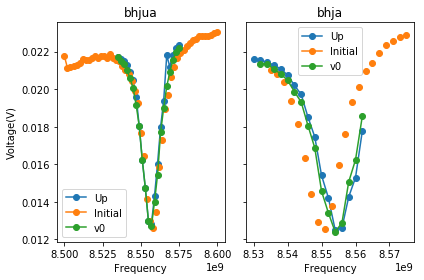

In [10]:
samples = da_bv.indexes['sample']
size = len(samples)
fig, axes = plt.subplots(1,size, figsize = (3*size,2*size) , sharey = True, squeeze=False)

for i, samp in enumerate(samples):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna('freq','all')
    axes[0][i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
    swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
    axes[0][i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    v0= v0s.sel(sample = samp,direction = 'U').dropna('freq','all')
    axes[0][i].plot(v0.to_series(),marker = 'o',label = 'v0')
    axes[0][i].set_title(samp)
    axes[0][i].legend()
    axes[0][i].set_xlabel('Frequency')
    axes[0][0].set_ylabel('Voltage(V)') 

    fig.tight_layout()

## fitting setup

Define fit parameters

In [11]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = None
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','w','R','Rinf'] 
    epsilon = 0.001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

# TODO: need to pass out all covariance only happening for one lor fn
    
elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    

time1 = 500e-9
time2 = 1500e-9
timerange = slice(time1,time2)
timestep = 10e-9 #not index and has been moved inside for loop...need to check

direcs = ['U']
samps = v0s.indexes['sample']
# samps = ['bia','bid']
flus = slice(-1,0,-1)
seldicts = list(analysis.dict_product({'sample' :samps, 'direction':direcs}))


Initialize data and perform fits

In [12]:
###Setup dictionaries to input paramters into
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_dcs.isel(freqt = 0).drop('freqt').isel(freq = 0).drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)

ds_p_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
ds_cov_r  =  ds_p.sel(time = timerange).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
Ks = pd.Series(index = samps)

###Generate Vshift data array
dvs = da_dv.sel(time = timerange)
vss = v0s + dvs

###Create data arrays to put fits into
fits_v0 = v0s.copy(deep= True).where(False)
fits = dvs.copy(deep = True).where(False)

#numer of fits for percent indicator, not working. 
num = len(seldicts)*(abs(flus.stop - flus.start))
### FITTING

for seldict in seldicts:
    clear_output(wait = True)
    
    ### V0 fitting
    v0 = v0s.sel(seldict).dropna('freq','all')
    samp = seldict['sample']
    direc = seldict['direction']
    
    p0[0] = None
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    popt = v0_p[0]
    freqs = v0s.indexes['freq'][v0_sl]
    fits_v0.loc[samp,direc] = v0_fit(freqs)

    for j, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp,direc] = popt[j]
    
    Ks[samp] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2]/popt[3], printparams = False)
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
    
    ###Time Series fitting
    
    vs1 = vss.sel(seldict).dropna('fluence','all').dropna('freq','all').dropna('time','all')
    
    times = vs1.indexes['time']
    timeidx1 = pd.Series(abs(times-time1)).idxmin()
    timeidx2 = pd.Series(abs(times-time2)).idxmin()
    dt = times[1] - times[0]
    idxstep = int(timestep/dt)
    
    fittimes = times[slice(timeidx1,timeidx2,idxstep)]
#     print('fitting for time idxs ' + str(fittimes) )
    
    i=0
    numflus = len(vs1.indexes['fluence'][flus.start:flus.stop:flus.step])
    for flu in vs1.indexes['fluence'][flus]:
        vs2 = vs1.sel(fluence = flu)
        
        print(str((i/numflus)*100.0) + ' %') 
        i=i+1
        for time in fittimes:
            vs3 = vs2.dropna('freq','all').sel(time = time)
            
            p0[0] = None
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)
            popt = vs_p[0]
            pcov = vs_p[1]
            perr = np.sqrt(np.diag(pcov))

            freqs = vs3.indexes['freq'][vs_sl]
            fits.loc[samp,direc,freqs,flu,time] = vs_fit(freqs).values   # Note that freqs is also in the index, only updating the freqeuncies that correspond to that sample
            
            ds_p_r['f0'].loc[samp,direc,flu,time] = popt[0]
            ds_p_r['w'].loc[samp,direc,flu,time] = popt[1]
            ds_p_r['R'].loc[samp,direc,flu,time] = popt[2]
            ds_p_r['Rinf'].loc[samp,direc,flu,time] = popt[3]
            
            ds_cov_r['f0'].loc[samp,direc,flu,time] = perr[0]
            ds_cov_r['w'].loc[samp,direc,flu,time] = perr[1]
            ds_cov_r['R'].loc[samp,direc,flu,time] = perr[2]
            ds_cov_r['Rinf'].loc[samp,direc,flu,time] = perr[3]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)
print('done')

K sample bhja = 72328.06931638758
0.0 %
done


# Visualizing Fit results 

In [20]:
%matplotlib ipympl

samp = 'bhja'

### Pull out arrays for one sample and get rid of nas
dst = ds.sel(sample = samp).sel(direction = 'U').drop('direction')#.sel(time = times) #try drop any fluence nan...

fits_samp = dst['fits'].dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
fittimes = fits_samp.indexes['time']
#cut down dvs and fits to only fit times. 
dvs_samp = dst['dvs'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
vss_samp = dst['vss'].sel(time = fittimes).dropna('fluence','all').dropna('freq','all').dropna('time','all').isel(fluence = -1)#.isel(time = 0)
dst_samp = xr.merge([dvs_samp,fits_samp,vss_samp])


### Setup initial plot with items at time =0 eventually should be removed
v0 = v0s.sel(sample = samp).sel(direction = 'U').drop('direction').dropna('freq','all')
fit_v0 = fits_v0.loc[samp].sel(direction = 'U').drop('direction').dropna('freq','all')
dv = dst_samp['dvs'].isel(time = 0 )
fit = dst_samp['fits'].isel(time = 0 )
vs = dst_samp['vss'].isel(time = 0 )

# human readable time array for slider
hrtimes = fittimes.values*1e9
hrtimetup = (hrtimes[0],hrtimes[-1],hrtimes[1]-hrtimes[0])

fig, axes, lns = plot.vsplotxr(dv, vs = vs, fit = fit, v0 = v0, fit_v0 = fit_v0, plotkwargs={'figsize' : (10,8)})

axes[0].set_ylim([dvs_samp.min(),dvs_samp.max()])

interact(plot.inter_vsplot, timesel=hrtimetup   ,dst_samp = fixed(dst_samp),lns = fixed(lns), fig = fixed(fig));

FigureCanvasNbAgg()

interactive(children=(FloatSlider(value=999.7999999999977, description='timesel', max=1499.6, min=500.0, step=…

In [ ]:
#plot.sweepfitanim(dst, interval = 100)   # Not currently working

## Fit error 

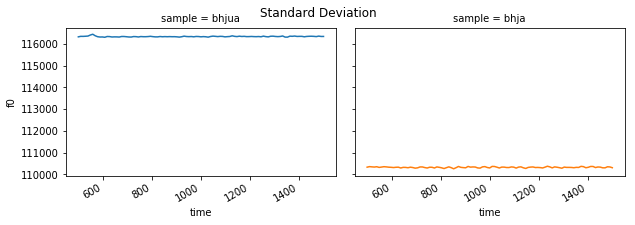

In [15]:
%matplotlib inline

g = ds_cov_r['f0'].sel(direction = 'U').dropna('fluence','all').plot(hue = 'fluence', col = 'sample')

for ax in g.axes[0]:
#     ax.set_yscale('log')
#     ax.set_ylim([-1,2])
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    
    lns = ax.lines
    for ln in lns:
        plot.dropna_ln(ln)
        
g.fig.suptitle('Standard Deviation')
g.fig.tight_layout()
g.fig.autofmt_xdate()
g.fig.legends[0].remove()

# Calculating the complex conductance 



In [16]:
# axes= [axes]
e0 = 8.854e-12
F=1

ft = ds_p_r['f0'].sel(direction ='U')
f0 = ft.isel(time = 0)
deltaf = ft-f0
sig_I_a = -1*deltaf*e0/F

wt = ds_p_r['w'].sel(direction ='U')
w0 = wt.isel(time = 0)
deltaFWHM = wt - w0
sig_R_a = deltaFWHM*e0/(2*F)

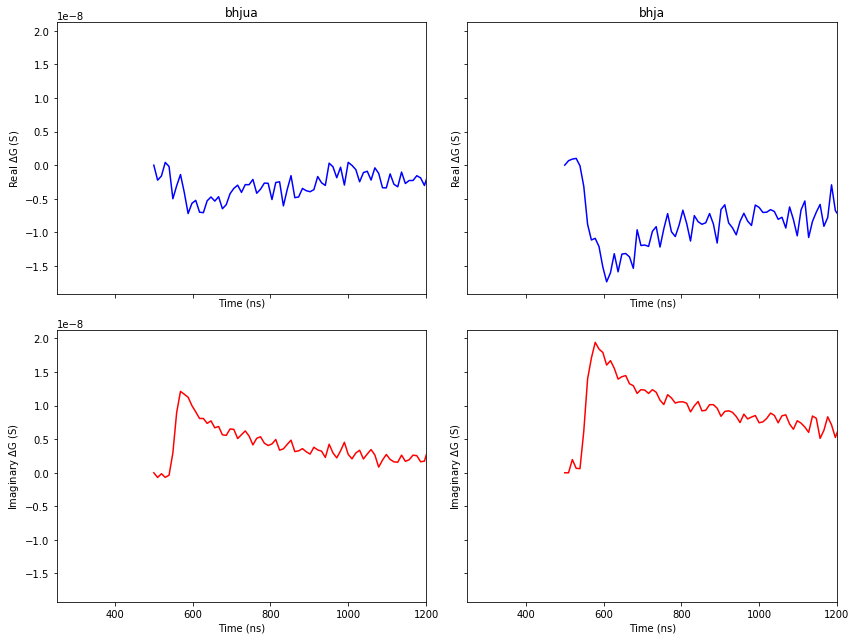

In [27]:
%matplotlib inline

fig, axes = plt.subplots(2,len(ds.indexes['sample']), figsize = (12,9), squeeze = False , sharey = True, sharex = True)

for i , samp in enumerate(ds_p_r.indexes['sample']):
    sig_Rs = sig_R_a.sel(sample = samp).dropna('fluence','all').dropna('time','all').copy(deep = True)
    sig_Is = sig_I_a.sel(sample = samp).dropna('fluence','all').dropna('time','all').copy(deep = True)
    for fluence in sig_Rs.indexes['fluence']:
        sig_R = sig_Rs.sel(fluence = fluence)
        sig_I = sig_Is.sel(fluence = fluence)
        label = '$\sigma^{\'}(\Delta FWHM)$'

        ax = axes[0][i]
        sig_R = sig_R.to_series()
        if np.trapz(sig_R) < 0:
            color = 'b'
#             sig_R = sig_R*-1
        else:
            color = 'r'
        ax.plot(sig_R, label = label, color = color)
#         ax.set_yscale('log')
#         ax.set_yscale('symlog',linthreshy=1e-9)
        ax.set_ylabel('Real $\Delta$G (S)')

        ax = axes[1][i]
        sig_I = sig_I.to_series()
        if np.trapz(sig_I) < 0:
            color = 'b'
#             sig_I = sig_I*-1
        else:
            color = 'r'
        ax.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$', color = color)
#         ax.set_yscale('log')
#         ax.set_yscale('symlog',linthreshy=1e-9)
        ax.set_ylabel('Imaginary $\Delta$G (S)')

    ax = axes[0][i]
    ax.set_title(samp)
for axs in axes:
    for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
        ax.set_xlim(250e-9,1200e-9)
        ax.set_xlabel('Time (ns)')
#         ax.set_ylim([1e-8,1e-4])

fig.tight_layout()

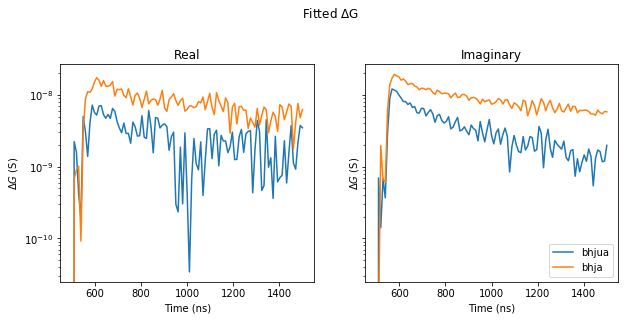

In [28]:
fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)

for sample in ds.indexes['sample']:
    sel = sig_R_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[0].plot(abs(sel.to_series()), label = sample)
    axes[0].set_title('Real')
    sel = sig_I_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[1].plot(abs(sel.to_series()), label = sample)
    axes[1].set_title('Imaginary')

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('$\Delta G$ (S)')
#     ax.set_xlim([200e-9,500e-9])
#     ax.set_ylim([1e-10,3e-8])
        
        
fig.suptitle('Fitted $\Delta$G', y = 1.08)
ax.legend()

## Ratio of real to imaginary 

In [29]:
ratio = sig_R_a/sig_I_a
ratio = ratio.isel(fluence = slice(-1,-10,-1)).sel(time = slice(200e-9,1000e-9)) # low fluences cause issues...need to fix to select actual fluence range

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


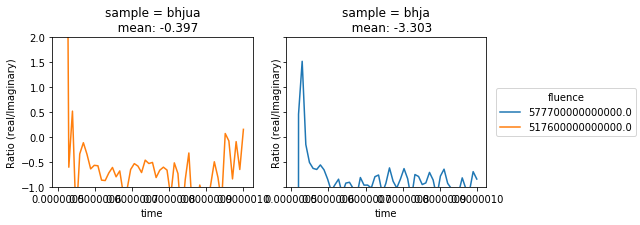

In [30]:
g = ratio.dropna('fluence','all').plot(x='time',hue = 'fluence',col = 'sample')

for ax in g.axes[0]:
    ax.set_ylim([-1,2])
    ax.set_ylabel('Ratio (real/Imaginary)')
    lns = ax.lines
    for ln in lns:
        plot.dropna_ln(ln)
        mean = ln.get_ydata().mean()
        if mean == mean:
            string = ax.title.get_text() + '\n   mean: ' + '{0:.3f}'.format(mean)
            ax.set_title(string)


C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5,1,'Average ratio over fluences')

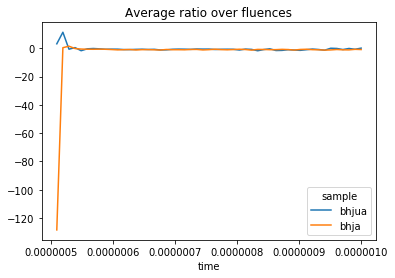

In [31]:
ratiomean = ratio.mean('fluence')
lns = ratiomean.plot(hue = 'sample')

for ln in lns:
    plot.dropna_ln(ln)

plt.title('Average ratio over fluences')

# Calculating (complex) figure of merit 

In [32]:
beta = 2.25
M = 0.25
FA = 1
e = 1.6e-19

def fom(x):
    fluence = x.coords['fluence'].values
    return x/(beta*e*fluence*FA*M)

fom_r = sig_R_a.groupby('fluence').apply(fom)
fom_i = sig_I_a.groupby('fluence').apply(fom)

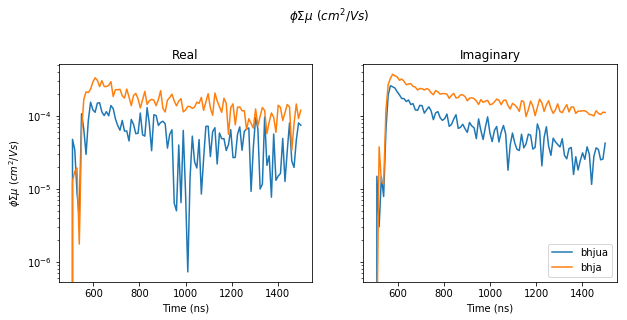

In [33]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)

for sample in ds.indexes['sample']:
    
    sel = fom_r.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[0].plot(abs(sel.to_series()), label = sample)
    axes[0].set_title('Real')
    sel = fom_i.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[1].plot(abs(sel.to_series()), label = sample)
    axes[1].set_title('Imaginary')

for ax in axes:
    
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_xlabel('Time (ns)')
    axes[0].set_ylabel('$\phi\Sigma\mu \ (cm^2/Vs)$')    
#     ax.set_xlim([200e-9,500e-9])
#     ax.set_ylim([1e-10,3e-8])
        

fig.suptitle('$\phi\Sigma\mu \ (cm^2/Vs)$', y = 1.08)
ax.legend()

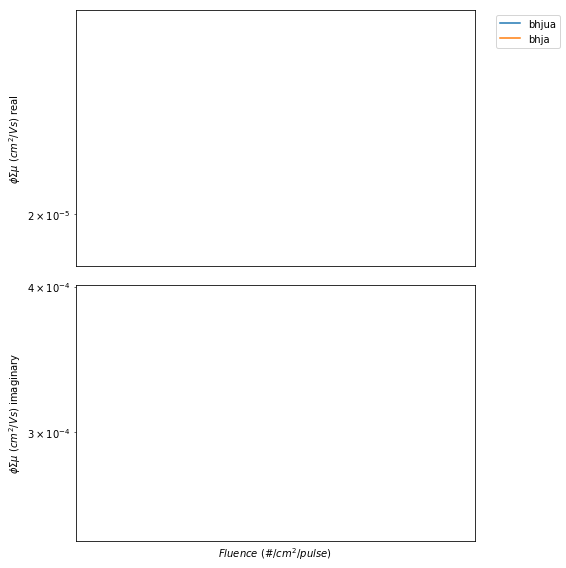

In [34]:
fig, axes = plt.subplots(2,1, figsize = (8,8))

for sample in fom_r.indexes['sample']:
    axes[0].plot(fom_r.max('time').sel(sample = sample).dropna('fluence','all').to_series(),label = sample)
    axes[1].plot(fom_i.max('time').sel(sample = sample).dropna('fluence','all').to_series(),label = sample)
    


for ax in axes:
    axes[0].set_ylabel('$\phi\Sigma\mu \ (cm^2/Vs) $ real')
    axes[1].set_ylabel('$\phi\Sigma\mu \ (cm^2/Vs) $ imaginary')
    axes[1].set_xlabel('$Fluence \ (\#/cm^2/pulse)$ ')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.margins(0.2)
axes[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")    
fig.tight_layout()